Inspired By:\
https://github.com/Utkarsh07/NLP_ASSIGNMENT-NER-Bi-LSTM-CRF/blob/master/ner.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tf2crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.6 MB/s eta 0:00:00


In [ ]:
!pip install sklearn_crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 16.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#CONLL data
class SentenceGetter(object):
    
    def __init__(self, filenames):
        self.sentences_map = {} #"train":[], valid
        self.filenames = filenames
        self.words = set()
        self.tags = set()
        niter = 0
        for filename in filenames:
          self.filename = filename
          self.sentences = []
          with open(self.filename) as f:
              sentence = []
              for line in f:
                  line = line.strip()
                  if (len(line) == 0 or line.startswith("-DOCSTART-")):
                      if len(sentence) != 0:
                        self.sentences.append(sentence)
                        sentence = []
                      continue
                  else:
                      ls = line.split(' ')
                      word, tag = ls[0],ls[3] #word - - tag
                      self.words.add(word)
                      self.tags.add(tag)
                      sentence.append((word,tag))
          if ("train" in filename):
            self.sentences_map["train"] = self.sentences
          elif ("valid" in filename):
            self.sentences_map["valid"] = self.sentences
          else:
            self.sentences_map["test"] = self.sentences

In [ ]:
files = ["/content/drive/MyDrive/MasterThesis/coNLL/train.txt", "/content/drive/MyDrive/MasterThesis/coNLL/valid.txt"]

In [ ]:
#CONLL data
getter = SentenceGetter(files)
sentences_map = getter.sentences_map
words = getter.words
tags = list(getter.tags)

In [ ]:
sentences_map["valid"][1:3]

[[('LONDON', 'B-LOC'), ('1996-08-30', 'O')],
 [('West', 'B-MISC'),
  ('Indian', 'I-MISC'),
  ('all-rounder', 'O'),
  ('Phil', 'B-PER'),
  ('Simmons', 'I-PER'),
  ('took', 'O'),
  ('four', 'O'),
  ('for', 'O'),
  ('38', 'O'),
  ('on', 'O'),
  ('Friday', 'O'),
  ('as', 'O'),
  ('Leicestershire', 'B-ORG'),
  ('beat', 'O'),
  ('Somerset', 'B-ORG'),
  ('by', 'O'),
  ('an', 'O'),
  ('innings', 'O'),
  ('and', 'O'),
  ('39', 'O'),
  ('runs', 'O'),
  ('in', 'O'),
  ('two', 'O'),
  ('days', 'O'),
  ('to', 'O'),
  ('take', 'O'),
  ('over', 'O'),
  ('at', 'O'),
  ('the', 'O'),
  ('head', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('county', 'O'),
  ('championship', 'O'),
  ('.', 'O')]]

In [ ]:
tags

['I-LOC', 'B-PER', 'B-LOC', 'I-ORG', 'O', 'I-MISC', 'B-ORG', 'I-PER', 'B-MISC']

In [ ]:
#CONLL data
words = list(words)

In [ ]:
tags.insert(0,'PAD')

In [ ]:
tags

['PAD',
 'I-LOC',
 'B-PER',
 'B-LOC',
 'I-ORG',
 'O',
 'I-MISC',
 'B-ORG',
 'I-PER',
 'B-MISC']

In [ ]:
from future.utils import iteritems

word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["PAD"] = 0 # Padding
word2idx["UNK"] = 1 # Unknown

tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [ ]:
#CONLL data

n_words = len(words)
n_tags = len(tags)

In [ ]:
tag2idx

{'PAD': 0,
 'I-LOC': 1,
 'B-PER': 2,
 'B-LOC': 3,
 'I-ORG': 4,
 'O': 5,
 'I-MISC': 6,
 'B-ORG': 7,
 'I-PER': 8,
 'B-MISC': 9}

In [ ]:
#CONLL data
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences_map["train"]])

train_data = [[word2idx[w[0]] for w in s] for s in sentences_map["train"]]
X_train = pad_sequences(maxlen=maxlen, sequences=train_data, dtype='int32', padding="post",value=word2idx["PAD"])
y_label_train = [[tag2idx[w[1]] for w in s] for s in sentences_map["train"]]
train_label = pad_sequences(maxlen=maxlen, sequences=y_label_train, dtype='int32', padding="post", value=tag2idx["PAD"])
# One-Hot encode
y_train = [to_categorical(i, num_classes=n_tags) for i in train_label]  # n_tags+1(PAD)

val_data = [[word2idx[w[0]] for w in s] for s in sentences_map["valid"]]
X_val = pad_sequences(maxlen=maxlen, sequences=val_data, dtype='int32', padding="post",value=word2idx["PAD"])
y_label_val = [[tag2idx[w[1]] for w in s] for s in sentences_map["valid"]]
val_label = pad_sequences(maxlen=maxlen, sequences=y_label_val, dtype='int32', padding="post", value=tag2idx["PAD"])
# One-Hot encode
y_val = [to_categorical(i, num_classes=n_tags) for i in val_label]

getter = SentenceGetter(["/content/drive/MyDrive/MasterThesis/coNLL/test.txt"])
sentences_test = getter.sentences_map["test"]
test_data = [[word2idx[w[0]] if w[0] in word2idx else word2idx["UNK"] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=maxlen, sequences=test_data, dtype='int32', padding="post",value=word2idx["PAD"])
y_label_test = [[tag2idx[w[1]] for w in s] for s in sentences_test]
test_label = pad_sequences(maxlen=maxlen, sequences=y_label_test, dtype='int32', padding="post", value=tag2idx["PAD"])
# One-Hot encode
y_test = [to_categorical(i, num_classes=n_tags) for i in test_label]


print(
        'train_tokens length:', len(X_train),
        '\nval_tokens length:', len(X_val),
        '\ntest_tokens length:', len(X_test),
        '\ntrain_tags:', len(y_train),
        '\nval_tags:', len(y_val),
        '\ntest_tags:', len(y_test)
    )


train_tokens length: 14041 
val_tokens length: 3250 
test_tokens length: 3453 
train_tags: 14041 
val_tags: 3250 
test_tags: 3453


In [ ]:
for token, tag in zip(X_train[0], y_train[0]):
    print('%s\t%s' % (token, tag))

#Model

In [ ]:
import tensorflow

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = n_words
input_length = maxlen
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  26885 
input_length:  113 
n_tags:  10


In [ ]:
import numpy as np
import tensorflow.keras as kk
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import GRU, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tf2crf import CRF, ModelWithCRFLoss

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
word_embedding_size = 40
units_size = 50

#input layer
input = Input(shape=(maxlen,))

# Embedding Layer
embed = Embedding(input_dim=input_dim, output_dim=word_embedding_size, input_length=maxlen, mask_zero=True)(input)#Construct the sequence of layers-functional api

# BI-LSTM Layer
model = Bidirectional(GRU(units=units_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=kk.initializers.he_normal()))(embed)

# TimeDistributed Layer
model = TimeDistributed(Dense(units_size, activation="relu"))(model) 

# CRF Layer
crf = CRF(units=n_tags)

output = crf(model)

base_model = Model(input, output)
base_model.summary()

model = ModelWithCRFLoss(base_model, sparse_target=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 embedding (Embedding)       (None, 113, 40)           1075400   
                                                                 
 bidirectional (Bidirectiona  (None, 113, 100)         27600     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 113, 50)          5050      
 ibuted)                                                         
                                                                 
 crf (CRF)                   ((None, 113),             610       
                              (None, 113, 10),                   
                              (None,),                       

In [ ]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
# adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model
# model.compile(optimizer=adam)
model.compile(optimizer="rmsprop")



# Saving the best model only
filepath="ner-bi-gru-tf2crf-model-{accuracy:.2f}.tf"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, np.array(y_train), validation_data = (X_val, np.array(y_val)), batch_size=256, epochs=20, verbose=1, callbacks=callbacks_list)

Epoch 1/20
55/55 [==============================] - ETA: 0s - loss: 13.5724 - accuracy: 0.7865
Epoch 1: accuracy improved from -inf to 0.78648, saving model to ner-bi-gru-tf2crf-model-0.79.tf


55/55 [==============================] - 142s 2s/step - loss: 13.5724 - accuracy: 0.7865 - val_loss_val: 9.9802 - val_val_accuracy: 0.8327
Epoch 2/20
55/55 [==============================] - ETA: 0s - loss: 7.0651 - accuracy: 0.8508
Epoch 2: accuracy improved from 0.78648 to 0.85081, saving model to ner-bi-gru-tf2crf-model-0.85.tf


55/55 [==============================] - 107s 2s/step - loss: 7.0651 - accuracy: 0.8508 - val_loss_val: 7.0299 - val_val_accuracy: 0.8674
Epoch 3/20
55/55 [==============================] - ETA: 0s - loss: 4.8850 - accuracy: 0.8942
Epoch 3: accuracy improved from 0.85081 to 0.89418, saving model to ner-bi-gru-tf2crf-model-0.89.tf


55/55 [==============================] - 101s 2s/step - loss: 4.8850 - accuracy: 0.8942 - val_loss_val: 5.5202 - val_val_accuracy: 0.8997
Epoch 4/20
55/55 [==============================] - ETA: 0s - loss: 3.2374 - accuracy: 0.9360
Epoch 4: accuracy improved from 0.89418 to 0.93600, saving model to ner-bi-gru-tf2crf-model-0.94.tf


55/55 [==============================] - 102s 2s/step - loss: 3.2374 - accuracy: 0.9360 - val_loss_val: 4.3940 - val_val_accuracy: 0.9229
Epoch 5/20
55/55 [==============================] - ETA: 0s - loss: 2.1276 - accuracy: 0.9596
Epoch 5: accuracy improved from 0.93600 to 0.95958, saving model to ner-bi-gru-tf2crf-model-0.96.tf


55/55 [==============================] - 102s 2s/step - loss: 2.1276 - accuracy: 0.9596 - val_loss_val: 3.7880 - val_val_accuracy: 0.9325
Epoch 6/20
55/55 [==============================] - ETA: 0s - loss: 1.4905 - accuracy: 0.9718
Epoch 6: accuracy improved from 0.95958 to 0.97179, saving model to ner-bi-gru-tf2crf-model-0.97.tf


55/55 [==============================] - 99s 2s/step - loss: 1.4905 - accuracy: 0.9718 - val_loss_val: 3.4779 - val_val_accuracy: 0.9388
Epoch 7/20
55/55 [==============================] - ETA: 0s - loss: 1.1176 - accuracy: 0.9788
Epoch 7: accuracy improved from 0.97179 to 0.97875, saving model to ner-bi-gru-tf2crf-model-0.98.tf


55/55 [==============================] - 99s 2s/step - loss: 1.1176 - accuracy: 0.9788 - val_loss_val: 3.2213 - val_val_accuracy: 0.9429
Epoch 8/20
55/55 [==============================] - ETA: 0s - loss: 0.8762 - accuracy: 0.9834
Epoch 8: accuracy improved from 0.97875 to 0.98336, saving model to ner-bi-gru-tf2crf-model-0.98.tf


55/55 [==============================] - 99s 2s/step - loss: 0.8762 - accuracy: 0.9834 - val_loss_val: 3.1657 - val_val_accuracy: 0.9436
Epoch 9/20
55/55 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.9863
Epoch 9: accuracy improved from 0.98336 to 0.98629, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 97s 2s/step - loss: 0.7183 - accuracy: 0.9863 - val_loss_val: 3.1047 - val_val_accuracy: 0.9443
Epoch 10/20
55/55 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.9884
Epoch 10: accuracy improved from 0.98629 to 0.98841, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 97s 2s/step - loss: 0.6079 - accuracy: 0.9884 - val_loss_val: 2.9799 - val_val_accuracy: 0.9478
Epoch 11/20
55/55 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.9901
Epoch 11: accuracy improved from 0.98841 to 0.99006, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 96s 2s/step - loss: 0.5119 - accuracy: 0.9901 - val_loss_val: 2.9799 - val_val_accuracy: 0.9487
Epoch 12/20
55/55 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.9912
Epoch 12: accuracy improved from 0.99006 to 0.99121, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 96s 2s/step - loss: 0.4536 - accuracy: 0.9912 - val_loss_val: 2.9180 - val_val_accuracy: 0.9489
Epoch 13/20
55/55 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.9922
Epoch 13: accuracy improved from 0.99121 to 0.99217, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 96s 2s/step - loss: 0.4016 - accuracy: 0.9922 - val_loss_val: 2.8317 - val_val_accuracy: 0.9499
Epoch 14/20
55/55 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.9930
Epoch 14: accuracy improved from 0.99217 to 0.99295, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 96s 2s/step - loss: 0.3523 - accuracy: 0.9930 - val_loss_val: 2.9043 - val_val_accuracy: 0.9479
Epoch 15/20
55/55 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.9938
Epoch 15: accuracy improved from 0.99295 to 0.99376, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 98s 2s/step - loss: 0.3133 - accuracy: 0.9938 - val_loss_val: 2.9856 - val_val_accuracy: 0.9483
Epoch 16/20
55/55 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.9943
Epoch 16: accuracy improved from 0.99376 to 0.99433, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 97s 2s/step - loss: 0.2844 - accuracy: 0.9943 - val_loss_val: 3.0440 - val_val_accuracy: 0.9497
Epoch 17/20
55/55 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9946
Epoch 17: accuracy improved from 0.99433 to 0.99457, saving model to ner-bi-gru-tf2crf-model-0.99.tf


55/55 [==============================] - 95s 2s/step - loss: 0.2663 - accuracy: 0.9946 - val_loss_val: 2.9439 - val_val_accuracy: 0.9492
Epoch 18/20
55/55 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9951
Epoch 18: accuracy improved from 0.99457 to 0.99505, saving model to ner-bi-gru-tf2crf-model-1.00.tf


55/55 [==============================] - 96s 2s/step - loss: 0.2472 - accuracy: 0.9951 - val_loss_val: 2.9136 - val_val_accuracy: 0.9504
Epoch 19/20
55/55 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9954
Epoch 19: accuracy improved from 0.99505 to 0.99545, saving model to ner-bi-gru-tf2crf-model-1.00.tf


55/55 [==============================] - 97s 2s/step - loss: 0.2218 - accuracy: 0.9954 - val_loss_val: 2.8773 - val_val_accuracy: 0.9491
Epoch 20/20
55/55 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9960
Epoch 20: accuracy improved from 0.99545 to 0.99596, saving model to ner-bi-gru-tf2crf-model-1.00.tf


55/55 [==============================] - 97s 2s/step - loss: 0.2018 - accuracy: 0.9960 - val_loss_val: 2.9899 - val_val_accuracy: 0.9496


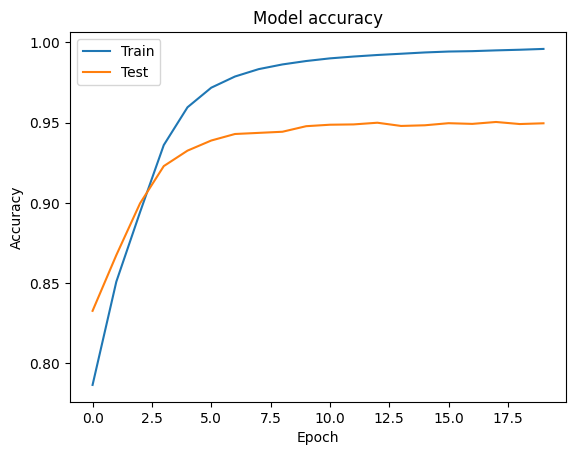

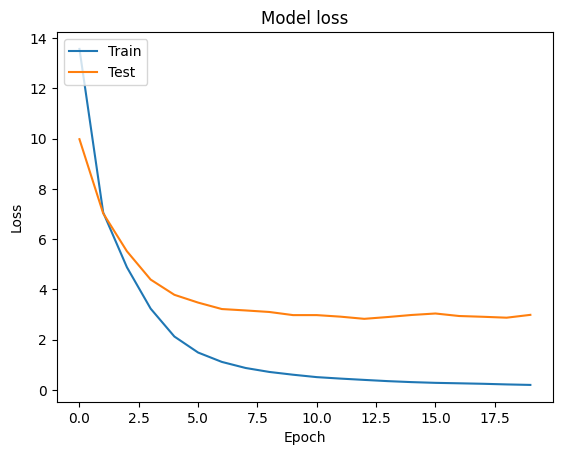

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss_val'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Prediction
pred_cat = model.predict(X_test, verbose=1)
y_te_true = np.argmax(y_test, -1)

108/108 [==============================] - 20s 175ms/step


In [ ]:
#New classification report
from sklearn_crfsuite.utils import flatten
from functools import wraps


def _flattens_y(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        y_true_flat = flatten(y_true)
        y_pred_flat = flatten(y_pred)
        return func(y_true_flat, y_pred_flat, *args, **kwargs)
    return wrapper


@_flattens_y
def flat_classification_report(y_true, y_pred, labels=None, target_names=None, **kwargs):
    """
    Return classification report for sequence items.
    """
    from sklearn import metrics
    return metrics.classification_report(y_true, y_pred, labels=labels, target_names=target_names, **kwargs)

In [ ]:
#Flat Classification report
report = flat_classification_report(y_te_true, pred_cat, target_names=tags)
print(report)

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00    343765
       I-LOC       0.36      0.79      0.49       257
       B-PER       0.92      0.67      0.77      1616
       B-LOC       0.72      0.89      0.80      1667
       I-ORG       0.65      0.78      0.71       835
           O       0.97      0.97      0.97     38316
      I-MISC       0.50      0.68      0.57       216
       B-ORG       0.77      0.72      0.74      1660
       I-PER       0.89      0.82      0.85      1155
      B-MISC       0.78      0.73      0.75       702

    accuracy                           0.99    390189
   macro avg       0.76      0.80      0.77    390189
weighted avg       0.99      0.99      0.99    390189



In [ ]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_test[i]]))
# p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

1/1 [==============================] - 0s 406ms/step
Sample number 1061 of 3453 (Test Set)
Word           ||True ||Pred
Before         : O     O
non-inflationary: B-PER O
's             : O     O
statement      : O     O
,              : O     O
Major          : B-PER O
had            : O     O
a              : O     O
non-inflationary: O     O
majority       : O     O
in             : O     O
the            : O     O
non-inflationary: O     B-ORG
House          : B-ORG I-ORG
of             : I-ORG I-ORG
Commons        : I-ORG I-ORG
lower          : O     O
house          : O     O
of             : O     O
parliament     : O     O
.              : O     O
